In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import nltk

# Download necessary NLTK data (run these lines ONCE)
# You might get a pop-up window the first time, or it might download silently.
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4') # Often needed with wordnet
except LookupError:
    nltk.download('omw-1.4')

print("NLTK data check complete. Proceeding with the notebook.")

NLTK data check complete. Proceeding with the notebook.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import nltk
nltk.download('punkt_tab') # Try this first, as the error explicitly asks for it.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# --- Preprocessing Function (from Day 8 - ensure NLTK data is downloaded) ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return " ".join(lemmatized_tokens) # Join back into a string for Tokenizer

# --- Sample Dataset (from Day 10) ---
data = {
    'text': [
        "This movie is fantastic and I loved it!",
        "What a terrible film, absolutely hated it.",
        "The food was good, but the service was slow.",
        "Excellent experience, highly recommend.",
        "I regret wasting my time on this boring show.",
        "Happy with the purchase, great product.",
        "Worst customer service ever, very disappointed.",
        "A surprisingly good story, well written."
    ],
    'sentiment': [
        'positive', 'negative', 'negative', 'positive',
        'negative', 'positive', 'negative', 'positive'
    ]
}
df = pd.DataFrame(data)
df['processed_text'] = df['text'].apply(preprocess_text)

X_text = df['processed_text'] # Use the preprocessed text string for Tokenizer
y = df['sentiment']

# --- Label Encoding for y (from Day 11) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Label mapping: {list(label_encoder.classes_)} -> {label_encoder.transform(label_encoder.classes_)}")

# --- 1. Tokenize Text for Embedding Layer ---
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: token to represent out-of-vocabulary words.
tokenizer = Tokenizer(num_words=500, oov_token="<unk>") # A small vocab size for our tiny dataset
tokenizer.fit_on_texts(X_text)

print(f"\nVocabulary size learned by Tokenizer: {len(tokenizer.word_index)}")
print(f"Sample word index (first 10): {list(tokenizer.word_index.items())[:10]}")

# 2. Convert texts to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X_text)
print(f"\nOriginal sequences (first 2): {X_sequences[:2]}")

# 3. Pad sequences to ensure uniform length
# maxlen: The maximum length of all sequences. Shorter sequences are padded, longer are truncated.
# padding: 'post' adds padding at the end, 'pre' at the beginning.
# truncating: 'post' truncates from the end, 'pre' from the beginning.
max_sequence_length = max(len(seq) for seq in X_sequences) # Find the max length in our small dataset
print(f"Max sequence length: {max_sequence_length}")

X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
print(f"Padded sequences (first 2):\n{X_padded[:2]}")
print(f"Shape of padded sequences: {X_padded.shape}")

# --- Train-Test Split (using the new X_padded data) ---
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_padded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"\nTraining set size: {X_train_seq.shape[0]} samples")
print(f"Test set size: {X_test_seq.shape[0]} samples")

Label mapping: ['negative', 'positive'] -> [0 1]

Vocabulary size learned by Tokenizer: 33
Sample word index (first 10): [('<unk>', 1), ('good', 2), ('service', 3), ('movie', 4), ('fantastic', 5), ('loved', 6), ('terrible', 7), ('film', 8), ('absolutely', 9), ('hated', 10)]

Original sequences (first 2): [[4, 5, 6], [7, 8, 9, 10]]
Max sequence length: 5
Padded sequences (first 2):
[[ 4  5  6  0  0]
 [ 7  8  9 10  0]]
Shape of padded sequences: (8, 5)

Training set size: 5 samples
Test set size: 3 samples



--- LSTM Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- LSTM Model Training ---
LSTM Model Training Finished.


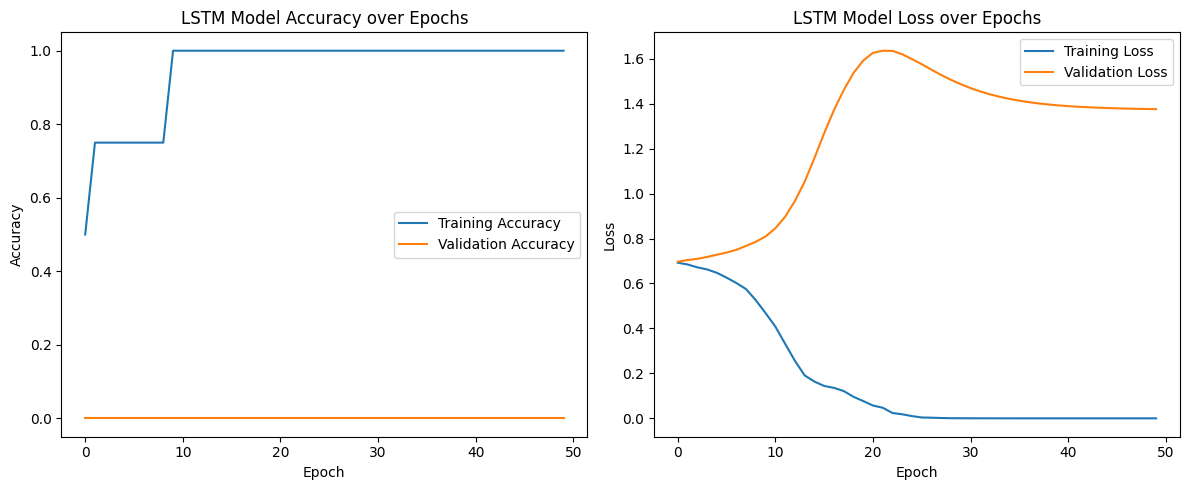

In [6]:
# --- Build the LSTM Model ---
# Vocabulary size (add 1 because indices start from 1, and 0 is reserved for padding)
vocab_size = len(tokenizer.word_index) + 1
# Dimension of the word embeddings (a hyperparameter you can tune)
embedding_dim = 100
# Max sequence length (from Assignment 2)
max_len = X_padded.shape[1]

model_lstm = Sequential([
    # 1. Embedding Layer: Converts positive integer (word indices) into dense vectors of fixed size
    # input_dim: size of the vocabulary
    # output_dim: dimension of the dense embedding
    # input_length: length of input sequences
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    # 2. LSTM Layer: Processes sequences. Returns either the last output or the full sequence of outputs.
    # units: dimensionality of the output space (e.g., number of LSTM cells)
    LSTM(units=128), # You can try different units like 64, 256
    # 3. Dense Hidden Layer (Optional but often helps)
    Dense(64, activation='relu'),
    # 4. Output Layer: Single neuron for binary classification with sigmoid activation
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print("\n--- LSTM Model Summary ---")
model_lstm.summary()

# Train the model
print("\n--- LSTM Model Training ---")
history_lstm = model_lstm.fit(X_train_seq, y_train_seq,
                              epochs=50, # More epochs than FNN as LSTMs learn more complex patterns
                              batch_size=2,
                              validation_split=0.1,
                              verbose=0)

print("LSTM Model Training Finished.")

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# 1. Evaluate the LSTM model on the test data
print("\n--- LSTM Model Evaluation ---")
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss (LSTM): {loss_lstm:.4f}")
print(f"Test Accuracy (LSTM): {accuracy_lstm:.4f}")

# 2. Make predictions (probabilities) on the test data
y_pred_probs_lstm = model_lstm.predict(X_test_seq)
print(f"\nSample Prediction Probabilities (first 5):\n{y_pred_probs_lstm[:5].flatten()}")

# Convert probabilities to binary class labels
y_pred_classes_lstm = (y_pred_probs_lstm > 0.5).astype(int)
print(f"Sample Predicted Classes (first 5): {y_pred_classes_lstm[:5].flatten()}")
print(f"Actual Test Classes (first 5): {y_test_seq[:5]}")

# Decode predicted numerical labels back to original sentiment strings
y_pred_sentiment_lstm = label_encoder.inverse_transform(y_pred_classes_lstm.flatten())
y_test_sentiment_lstm = label_encoder.inverse_transform(y_test_seq)

print(f"\nSample Predicted Sentiments (first 5): {y_pred_sentiment_lstm[:5]}")
print(f"Actual Test Sentiments (first 5): {y_test_sentiment_lstm[:5]}")

# Print Classification Report for LSTM
print("\nClassification Report for LSTM:")
print(classification_report(y_test_sentiment_lstm, y_pred_sentiment_lstm))

# --- Predict on New Input Text with LSTM Model ---
print("\n--- Predicting on New Input Text with LSTM Model ---")

new_text_lstm_pos = "This product is incredibly well-made and provides an outstanding experience."
new_text_lstm_neg = "This is the absolute worst experience I have ever had. Truly awful."

# 1. Preprocess new text
processed_new_text_lstm_pos = preprocess_text(new_text_lstm_pos)
processed_new_text_lstm_neg = preprocess_text(new_text_lstm_neg)

print(f"\nOriginal New Text (Positive): '{new_text_lstm_pos}'")
print(f"Preprocessed New Text (Positive): '{processed_new_text_lstm_pos}'")
print(f"\nOriginal New Text (Negative): '{new_text_lstm_neg}'")
print(f"Preprocessed New Text (Negative): '{processed_new_text_lstm_neg}'")

# 2. Convert new text to sequences (using the *same* fitted tokenizer)
new_seq_pos = tokenizer.texts_to_sequences([processed_new_text_lstm_pos])
new_seq_neg = tokenizer.texts_to_sequences([processed_new_text_lstm_neg])

# 3. Pad the new sequences (using the *same* max_len)
new_padded_seq_pos = pad_sequences(new_seq_pos, maxlen=max_len, padding='post', truncating='post')
new_padded_seq_neg = pad_sequences(new_seq_neg, maxlen=max_len, padding='post', truncating='post')

# 4. Make predictions (probabilities)
prediction_prob_lstm_pos = model_lstm.predict(new_padded_seq_pos)[0][0]
prediction_prob_lstm_neg = model_lstm.predict(new_padded_seq_neg)[0][0]

# Convert probabilities to class labels
predicted_class_lstm_pos = (prediction_prob_lstm_pos > 0.5).astype(int)
predicted_class_lstm_neg = (prediction_prob_lstm_neg > 0.5).astype(int)

# Decode numerical labels back to sentiment strings
predicted_sentiment_lstm_pos = label_encoder.inverse_transform([predicted_class_lstm_pos])[0]
predicted_sentiment_lstm_neg = label_encoder.inverse_transform([predicted_class_lstm_neg])[0]

print(f"\nNew Text (Positive): '{new_text_lstm_pos}'")
print(f"Predicted Probability (LSTM): {prediction_prob_lstm_pos:.4f}")
print(f"Predicted Sentiment (LSTM): {predicted_sentiment_lstm_pos}")

print(f"\nNew Text (Negative): '{new_text_lstm_neg}'")
print(f"Predicted Probability (LSTM): {prediction_prob_lstm_neg:.4f}")
print(f"Predicted Sentiment (LSTM): {predicted_sentiment_lstm_neg}")


--- LSTM Model Evaluation ---
Test Loss (LSTM): 1.5713
Test Accuracy (LSTM): 0.6667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step

Sample Prediction Probabilities (first 5):
[0.98793614 0.25167283 0.9936699 ]
Sample Predicted Classes (first 5): [1 0 1]
Actual Test Classes (first 5): [0 0 1]

Sample Predicted Sentiments (first 5): ['positive' 'negative' 'positive']
Actual Test Sentiments (first 5): ['negative' 'negative' 'positive']

Classification Report for LSTM:
              precision    recall  f1-score   support

    negative       1.00      0.50      0.67         2
    positive       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3


--- Predicting on New Input Text with LSTM Model ---

Original New Text (Positive): 'This product is incredibly well-made and provides an outstanding experience.'
Preprocessed New Text (Positive): 'product inc